<a href="https://colab.research.google.com/github/surajjeoor/ITNPAI_Project_Forestcityclassifier/blob/main/ITNPAI1__VGGNet_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

#University of Stirling - Spring 2023

## ITNPAI1 - Deep Learning for Vision and NLP (2022/3)

---

---

# 1. **Problem definition** 
There is a need to create reliable and effective techniques to automatically categorise photos given the increasing volume of digital imagery. The richness and unpredictability of image information, as well as the necessity for robustness to image variables like lighting, stance, and occlusion, make image classification a tough task. A crucial area of research, picture categorization is also a critical task in many industries, including robotics, security, and healthcare. Thus, it is necessary to create sophisticated computer vision methods that can identify images reliably and effectively in a variety of fields.

One of the most important jobs in computer vision is the assignment of a label or a category to an input image based on the visual content of the image. The following are some examples of how crucial Image classification is to computer vision:

Identifying objects in an image and classifying them into distinct classes or categories can aid in object detection. This is helpful in applications like self-driving automobiles where it is necessary to identify and track items like pedestrians, traffic signs, and other vehicles.

By classifying photographs according to their content, it is possible to find related pictures in a sizable database. This is helpful in systems like content-based picture retrieval systems and image search engines.

In order to complete the objective, a dataset of labelled photos from Accra, Ghana, and Pune, India, will be used as training data to create a computer vision model that can reliably categorise images containing forests from images containing streets. The next step is to assess the algorithm's performance using photos from Stirling, Scotland—that wasn't a part of the training set. The classification task entails classifying forests from streets ensuring that the system can correctly categorise the same across various cities and environmental situations, such as shifting lighting, weather, and background, will be a problem.

[top](#scrollTo=4i5afvUbhmGo)
 

---
# 2. **Dataset creation**

The dataset for this solution is already uploaded on the google drive

[top](#scrollTo=4i5afvUbhmGo)

---

# 3. **Dataloader**

The Dataloader in pytorch comes up with some image augmentation by default but in order to make the model more robust. We are mannually implementing data augmentation techniques like random flips, equalizing the histogram of the image and normalizing the pixels. Here we are using the image dataset function which creates the dataloader by keeping the path of the directory in consideration.

[top](scrollTo=4i5afvUbhmGo)

In [3]:
#load libraries
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
from torchsummary import summary
from torch.nn import LeakyReLU
import matplotlib.pyplot as plt




In [4]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#Importing libraries for authentication
from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [6]:
# Code for authentication

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)



In [7]:
#Image augmentation Compose
transforms_train=transforms.Compose([
    transforms.Resize((224,224)), #resizing the image according to the numbers of pixels
    transforms.RandomHorizontalFlip(0.5),#images will be flipped randomly with the probability of 50%
    transforms.ToTensor(),  # converts pixel resolution of 0-255 to 0-1
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]) #pixel normalization
])

transforms_test=transforms.Compose([
     transforms.Resize((224,224)),
    transforms.RandomEqualize(0.5), #Randomly equalizing the histogram of the image
    transforms.ToTensor()
])

In [8]:
#Dataloader preparation
train_path="/content/drive/MyDrive/Deep_Learning_Assignment/Classifier_dataset/train"
train_dataloader=DataLoader(torchvision.datasets.ImageFolder(train_path,transforms_train),batch_size=32,shuffle=True)
test_path="/content/drive/MyDrive/Deep_Learning_Assignment/Classifier_dataset/test"
test_dataloader=DataLoader(torchvision.datasets.ImageFolder(test_path,transforms_test),batch_size=32,shuffle=True)

---

# 4. **Proposed solution** 

In this particular solution, we have used VGG nets. VGG Network can be partitioned into two parts: the first consisting mostly of convolutional and pooling layers and the second consisting of fully connected layer

In this solution, first we implemented convolution layer that will accept input images of resolution 224X224 pixels.Then the batch normalization has been performed, then the output of batch normalization has been passed through the 
RelU function and that output is maxpooled. After this, we are looping the vggblocks according to number of blocks and input channels.

In each VGG block, We are passing lazy convolution layer. Lazy initialization can be convenient, allowing the framework to infer parameter shapes automatically, making it easy to modify architectures and eliminating one common source of errors.

After this block we have implemented ReLU function to introduce the non linearity. 

After RelU, We implemented the maxpooling layer.

After all of this,under the fully connected layer the input layers consists of 2048 nodes, the weights of these nodes passed to the hidden layes having 4096 nodes of which the weights of those nodes passed to another 4096 nodes. From there,all of these weights has been passed to the output layers that consists 2 nodes.


[top](#scrollTo=4i5afvUbhmGo)

In [9]:
#device initiallization
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
#device printing
print(device)

cpu


In [11]:
#setting up the root directory to extract the number of classes
root=pathlib.Path(train_path)

#Extracting the name of the classes from the assigned root directory, under which the image has to be classified
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [12]:
#printing the name of the classes
print(classes)

['Forests', 'Streets']


In [13]:
#Checking the shapes of the dataloader
for x,y in test_dataloader:
  print(y.shape)
  print(x.shape)

torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([8])
torch.Size([8, 3, 224, 224])


In [14]:
#definition of VGG block function
def vggblock(num_conv,out_channels):
  layers=[]
  for _ in range(num_conv):
    layers.append(nn.LazyConv2d(out_channels=out_channels,kernel_size=3,padding=2))
    layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
  return nn.Sequential(*layers)

In [15]:
#Designing the main layer
class Convnet(nn.Module):
  def __init__(self,arch=[],num_classes=2):
    super(Convnet,self).__init__()
    #Output size after convolution filter
    #(w-f+2P)/s+1

    #input shape = (64,3,224,224)
    self.convl=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
    #Shape=(64,12,224,224)
    self.bnl=nn.BatchNorm2d(num_features=12)
    #Shape=(64,12,224,224)
    self.relu1=nn.ReLU()

    self.pool=nn.MaxPool2d(kernel_size=2)
    #Reduce the image size by the factor of 2
    conv_blks=[]

    # Repeating the number of vggblocks according to the architecture described in the next code snippet
    for nums_convs,out_channels in arch:
      conv_blks.append(vggblock(nums_convs,out_channels))


    #merging all the blocks under the Sequential
    self.features=nn.Sequential(*conv_blks)  

    #From this juncture, Sequential network starts
    self.fc=nn.Sequential(
            nn.Flatten(),                                                                     # input: (b, 512, 2, 2) e output: (b, 512*2*2) = (b, 2048)
            nn.Linear(in_features=2048, out_features=4096),                                    # input: (b, 2048) e output: (b, 4096)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),                                                             # input: (b, 4096) e output: (b, 4096)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)                                                          # input: (b, 4096) e output: (b, 2)
        )
    
    #under the forward function we are composing all of the process which defined previously through which the input image will go through
  def forward(self,input):
      output=self.convl(input)
      output=self.bnl(output)
      output=self.relu1(output)
      output=self.pool(output)
      output=self.features(output)
      output=self.fc(output)
      return output


In [16]:
#defining the model with architecture arch
#in this block of code arch is the tuple of pairs of numbers under the format (number_of_vggblocks,number of filters)
#for example if there is (1,128), 1 will be number of vggblock/'s and 128 will be number of filters
model=Convnet(arch=((1, 128), (1, 256), (2, 512), (2, 1024), (2, 512)))

summary(model,(3,224,224))

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 12, 224, 224]             336
       BatchNorm2d-2         [-1, 12, 224, 224]              24
              ReLU-3         [-1, 12, 224, 224]               0
         MaxPool2d-4         [-1, 12, 112, 112]               0
            Conv2d-5        [-1, 128, 114, 114]          13,952
              ReLU-6        [-1, 128, 114, 114]               0
         MaxPool2d-7          [-1, 128, 57, 57]               0
            Conv2d-8          [-1, 256, 59, 59]         295,168
              ReLU-9          [-1, 256, 59, 59]               0
        MaxPool2d-10          [-1, 256, 29, 29]               0
           Conv2d-11          [-1, 512, 31, 31]       1,180,160
             ReLU-12          [-1, 512, 31, 31]               0
        MaxPool2d-13          [-1, 512, 15, 15]               0
           Conv2d-14          [-1, 512,

In [17]:
#Setting up the learning rate and weights decay
lr=0.1
wd_lambda=0.0001

#importing optim module from the torch library for the optimizer
from torch import optim

#Selecting optimizer as stochastic gradient descent
optimizer1=optim.SGD(model.parameters(),lr=0.01,weight_decay=0.0001,momentum=0.9)

#Setting up the loss function as cross entropy loss function
loss_function=nn.CrossEntropyLoss()

In [18]:
#Setting up number of epochs and determining the number of train count and test count.
num_epochs=20
train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))
print(train_count)
print(test_count)

200
200


In [19]:
#Defining the function for test and evaluation
def Model_test_eval(net,optimizer,loss):
    best_accuracy=0.0
    train_loss1=[]
    test_loss1=[]
    epoch1=[]
    train_acc1=[]
    test_acc1=[]
    for epoch in range(num_epochs):
      model.train()
      train_acc=0.0
      train_loss=0.0
      for i,(images,labels) in enumerate(train_dataloader):
        #checking if this system utilizing GPU
        if torch.cuda.is_available():
          images=Variable(images.cuda)
          labels=Variable(labels.cuda)
        #Initializing the optimizer to zero gradient  
        optimizer1.zero_grad()
        #Extracting Yhat by inputting images through the model
        outputs=net(images)

        #calculating loss
        loss1=loss(outputs,labels)

        #backward propagation
        loss1.backward()

        #updating the parameters
        optimizer.step()

        #assigning the train loss
        train_loss+=loss1.cpu().data*images.size(0)

        #predictingthe value
        _,prediction=torch.max(outputs.data,1)

        #Calculating the training accuracy and assigning loss function
        train_acc+=int(torch.sum(prediction==labels.data))

        train_accuracy=train_acc/train_count
        train_loss=train_loss/train_count

      #Testing the model on unseen ( i.e. testing data )
      net.eval()
      test_accuracy=0.0
      for i,(images,labels) in enumerate(test_dataloader):
        if torch.cuda.is_available():
          images=Variable(images.cuda)
          labels=Variable(labels.cuda)
      
        outputs=net(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))

        test_accuracy=test_accuracy/test_count

      print('Epoch:'+str(epoch)+' Train Loss :'+str(train_loss)+' Train Accuracy:'+str(train_accuracy)+' Test Accuracy:'+str(test_accuracy))
      train_loss1.append(train_loss)
      epoch1.append(epoch)
      train_acc1.append(train_accuracy)
      test_acc1.append(test_accuracy)
    return epoch1,train_acc1,test_acc1

---

# 5. **Experimental tests and evaluations** 

  - *E1* and *E2* - Training and testing the models.Here we are implementing both training and testing on the model and functions has been developed from the above code snippet under this function we are passing model, optimizer and the loss function.

  -*E3* - 
By keeping the models accuracy in consideration we did not went for this stage but we went for other solutions that has been provided under the github repository:

We tried changing hyper parameters like implementation of Adam optimizer and changing activation functions from RelU to LeakyRelU. But we observed no difference. It appears like due to incompatibility of images with models, the model is overfitting. It forced us to explore another solutions which has been shared under the following link:

https://github.com/surajjeoor/ITNPAI_Project_Forestcityclassifier

[top](#scrollTo=4i5afvUbhmGo)

In [20]:
# Training and testing models simultaneously

train_1=[]
test_1=[]
epoch1=[]

epoch1,train_acc1,test_acc1=Model_test_eval(model,optimizer=optimizer1,loss=loss_function)



Epoch:0 Train Loss :tensor(0.0283) Train Accuracy:0.5 Test Accuracy:0.015451511306454531
Epoch:1 Train Loss :tensor(0.0286) Train Accuracy:0.485 Test Accuracy:0.02045226129712586
Epoch:2 Train Loss :tensor(0.0283) Train Accuracy:0.435 Test Accuracy:0.035426632547126566
Epoch:3 Train Loss :tensor(0.0284) Train Accuracy:0.5 Test Accuracy:0.025452135047110466
Epoch:4 Train Loss :tensor(0.0284) Train Accuracy:0.5 Test Accuracy:0.015377386306469764
Epoch:5 Train Loss :tensor(0.0284) Train Accuracy:0.515 Test Accuracy:0.020476635040860936
Epoch:6 Train Loss :tensor(0.0283) Train Accuracy:0.49 Test Accuracy:0.020502383790829453
Epoch:7 Train Loss :tensor(0.0282) Train Accuracy:0.5 Test Accuracy:0.0203275094439075
Epoch:8 Train Loss :tensor(0.0278) Train Accuracy:0.5 Test Accuracy:0.030426760665891877
Epoch:9 Train Loss :tensor(0.0276) Train Accuracy:0.5 Test Accuracy:0.030351883806516877
Epoch:10 Train Loss :tensor(0.0278) Train Accuracy:0.5 Test Accuracy:0.0004022606752979687
Epoch:11 Train 

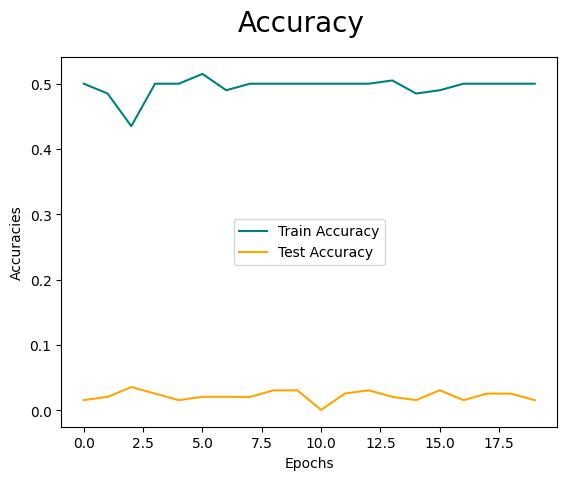

In [31]:
#plotting the training and testing accuracy from the model
plt.plot(epoch1,train_acc1,color='teal',label='Train Accuracy')
plt.plot(epoch1,test_acc1,color='orange',label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.suptitle('Accuracy',fontsize=20)
plt.legend(loc="center")
plt.show()
